In [1]:
import Pkg; Pkg.activate("./"); # Activate the project 
import Base.Threads
println("using $(Threads.nthreads()) threads")

  Activating project at `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks`


using 4 threads


In [1]:
# Import all the necessary libraries
libraries = ["BackAction", "LinearAlgebra", "Statistics", "Plots", "LaTeXStrings", 
            "OrdinaryDiffEq", "PyPlot"]

function ensure_imports(packages::Vector{String})
    for pkg in packages
        try
            @eval using $(Symbol(pkg))
        catch e
            if e isa ArgumentError && occursin(pkg, e.msg)
                println("Installing $pkg...")
                Pkg.add(pkg)
                @eval using $(Symbol(pkg))
            else
                rethrow(e)
            end
        end
    end
end

ensure_imports(libraries)

# Driven Qubit
The system of interest has hamiltonian:

$$ H = \frac{\Delta}{2} \sigma_z + \frac{\Omega}{2} \sigma_x$$

and jump operators

$$ L_1 = \sqrt{\gamma(\bar{n} +1 )}\sigma_- $$
$$ L_2 = \sqrt{\gamma\bar{n}}\sigma_- $$
(Wiseman, Equation 3.36)

## No drive nor Detuning Case $\Omega = 0, \Delta=0$
### Coordinates on the Bloch Sphere
$$ \dot{z}= -\gamma(2\bar{n}+1)(z + \frac{1}{2\bar{n}+1}) $$

In [12]:
########################## INITIALIZATION
# Define the hamiltonian
delta = 0.0 # Constant following Landi figure 7
gamma = 1.0
omega = 0.0
nbar = 0.5
H = 0.5*delta * BackAction.sigma_z + 0.5*omega*BackAction.sigma_x
# Define the jump operators
L1 = sqrt(gamma*(nbar+1))*BackAction.sigma_m
L2 = sqrt(gamma*(nbar))*BackAction.sigma_p
# Define the system
psi0 = zeros(ComplexF64, 2)
psi0[2] = 1
sys = System(H, [L1, L2])
params = SimulParameters(psi0,
    25.0, # Final time
    1, # seed
    10000, # Number of trajectories
    2500, # Number of samples in the finegrid
    1.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)

SimulParameters(psi0=ComplexF64[0.0 + 0.0im, 1.0 + 0.0im]
nsamples=2500
seed=1
ntraj=10000)
multiplier=1.0
tf=25.0
dt=0.01
eps=0.001)

In [13]:
# Analytical results
z0 = real(dot(psi0[:], BackAction.sigma_z * psi0[:]))
z_an(t) = ( 1/(2*nbar+1) + z0)*Base.MathConstants.e^(-gamma*(2*nbar+1)*t) - 1/(2*nbar+1)

z_an (generic function with 1 method)

In [14]:
# Generate trajectories
sample_clicks = run_trajectories_gillipsie(sys, params);

Sampling... 100%|██████████████████████████| Time: 0:00:03 ( 0.37 ms/it)


In [15]:
# Obtain states between jumps
ntimes = 1000
t = collect(LinRange(0, params.tf, ntimes))
sample_states = zeros(ComplexF64, sys.NLEVELS, ntimes, params.ntraj)
for k in 1:params.ntraj
    sample_states[:, :, k] = states_att(t, sample_clicks[k], sys, psi0)
end 

In [16]:
# Evaluate the occupation number of the excited state
@time begin
sample_occupation_e = zeros(Float64, ntimes,  params.ntraj)
sample_occupation_g = zeros(Float64, ntimes,  params.ntraj)
sample_sigma_z = zeros(Float64, ntimes,  params.ntraj)
number_e = BackAction.sigma_p * BackAction.sigma_m
number_g = BackAction.sigma_m * BackAction.sigma_p
for k in 1:params.ntraj
    for tn in 1:ntimes 
        sample_occupation_e[tn, k] = dot(sample_states[:, tn, k], number_e * sample_states[:, tn, k])
        sample_occupation_g[tn, k] = dot(sample_states[:, tn, k], number_g * sample_states[:, tn, k])
        sample_sigma_z[tn, k] = dot(sample_states[:, tn, k], BackAction.sigma_z * sample_states[:, tn, k])
    end 
end 
end

 45.214245 seconds (372.37 M allocations: 13.968 GiB, 6.19% gc time)


In [17]:
#Analyzing a given trajectory 
traj_index = 3
waiting_times = [click.time for click in sample_clicks[traj_index]] 
jump_times = cumsum(waiting_times)
times = Array{Float64}
jump_indeces = []
jump_labels = []
counter = 1
# Find the indices of the jumps
for t_jump in jump_times
    while (t[counter] < t_jump) && (counter < size(t)[1])
        counter = counter + 1
    end  
    if counter == size(t)[1]
        break
    end 
    push!(jump_indeces, counter)
end 

In [18]:
# Evaluate the net charge
traj = sample_clicks[3]
weights = [-1.0, 1.0]
function get_charge(t_given::Vector{Float64}, traj::Trajectory, weights::Vector{Float64})
    ntimes = size(t_given)[1]
    charge = zeros(Float64, ntimes)
    # Edge case: if the trajectory had no jumps, it has zero charge
    if isempty(traj)
        return charge
    end 
    njumps = size(traj)[1]
    wait_times = [click.time for click in traj] 
    jump_times = cumsum(wait_times)
    charge_counter = 0
    j_counter = 1
    t_counter = 1
    # Current for times before the final jump
    while j_counter < njumps
        while t_given[t_counter] < jump_times[j_counter]
            charge[t_counter] = charge_counter
            t_counter = t_counter + 1
            if t_counter > ntimes # if there are no more times, return
                return charge
            end 
        end 
        charge_counter = charge_counter + weights[traj[j_counter].label]
        j_counter = j_counter + 1
    end 
    # After the final jump 
    charge[t_counter:end] .= charge_counter
    return charge
end 

get_charge (generic function with 1 method)

In [19]:
# Obtain the current
current_sample = zeros(Float64, ntimes, params.ntraj)
for k in 1:params.ntraj
    charge = get_charge(t, sample_clicks[k], weights)
    for tn in 2:ntimes
        current_sample[tn, k] = (charge[tn] -  charge[tn-1]) # WARNING: THIS IS NOT NORMALIZED 
    end 
end 

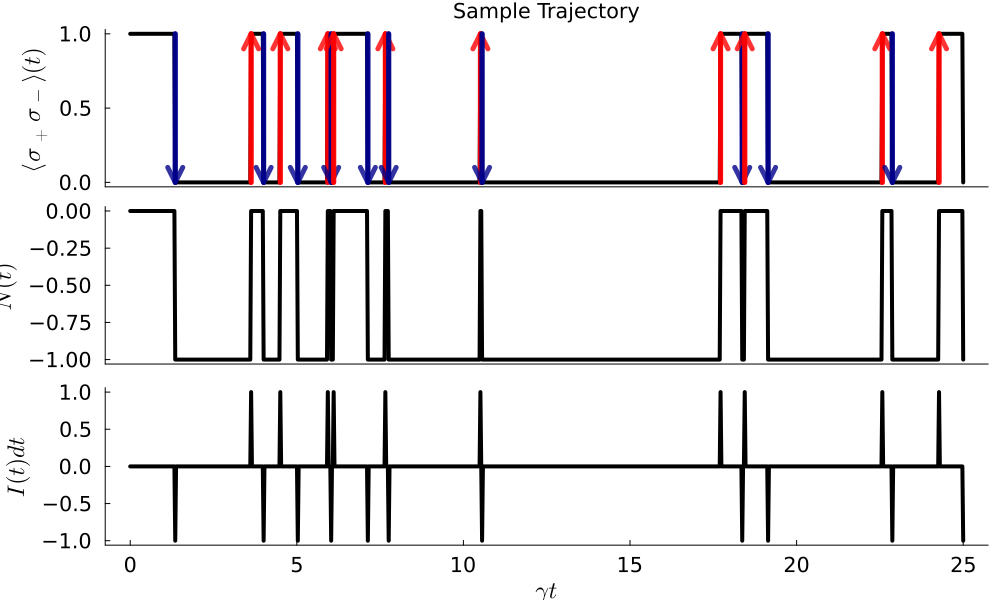

In [20]:
# Plot
charge_sample = get_charge(t, traj, weights)
p = Plots.plot(t, sample_occupation_e[:, traj_index], legend=false, linewidth=4, color="black",
             guidefont=font(16), grid=:false, gridalpha = 0.5, 
            ylabel = L"\langle\sigma_+\sigma_-\rangle(t)", title="Sample Trajectory", xticks=false,
            bottom_margin=0*Plots.mm, tickfont=font(14), yticks=[0.0, 0.5, 1.0])
# Add jump indicators
for j in jump_indeces
    if sample_occupation_e[j-1, traj_index] > sample_occupation_e[j+1, traj_index]
        Plots.plot!([t[j], t[j]], [sample_occupation_e[j-1, traj_index], sample_occupation_e[j+1, traj_index]],
              linewidth=5, alpha=0.8, color="darkblue", 
              arrow=:true, arrowsize=49)
    elseif sample_occupation_e[j-1, traj_index] < sample_occupation_e[j+0, traj_index]
        Plots.plot!([t[j], t[j]], [sample_occupation_e[j-1, traj_index], sample_occupation_e[j+1, traj_index]],
              linewidth=5, alpha=0.8, color="red", 
              arrow=:true, arrowsize=49)
    end 
end 
charge_plot = Plots.plot(t, charge_sample , color="black", linewidth=4, grid=:false, gridalpha = 0.5,
                    xticks=false, guidefont=(16), ylabel=L"N(t)", legend=:false)

current_plot = Plots.plot(t, current_sample[:, 3] , color="black", linewidth=4, grid=:false, gridalpha = 0.5,
                    xlabel=L"\gamma t", guidefont=(16), ylabel=L"I(t)dt", legend=:false)
Plots.plot(p, charge_plot ,current_plot, layout=(3,1), size=(1000, 600), tickfont=font(14))

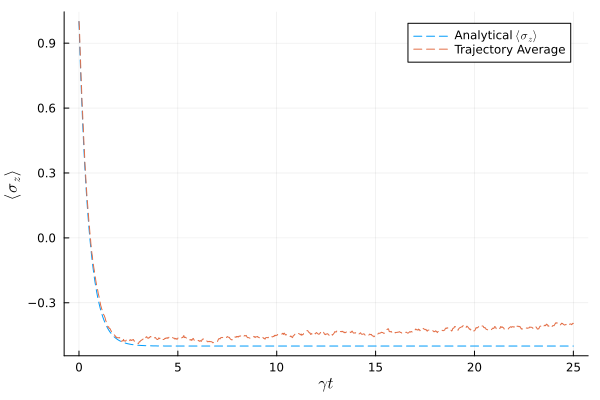

In [22]:
excited_population = dropdims(mean(sample_occupation_e, dims=2), dims=2)
ground_population = dropdims(mean(sample_occupation_g, dims=2), dims=2)
sz = dropdims(mean(sample_sigma_z, dims=2), dims=2)
average_current = gamma*nbar*ground_population - gamma*(nbar+0)*excited_population
Plots.plot(t/gamma, z_an.(t), label= L"Analytical $\langle\sigma_z\rangle$", line=:dash)
Plots.plot!(t/gamma, sz, line=:dash, xlabel=L"\gamma t", ylabel=L"$\langle\sigma_z\rangle$", label="Trajectory Average")

# General Case
The general case has the equation in the bloch sphere:

$$ \dot{x} = -\frac{\gamma}{2}(2\bar{n}+1)x - \Delta y + 0 $$
$$ \dot{y} = \Delta x -\frac{\gamma}{2}(2\bar{n}+1)y - \Omega z$$
$$ \dot{z} = 0 + \Omega y -\gamma(2\bar{n}+1)z - \gamma $$

In [23]:
########################## INITIALIZATION
# Define the hamiltonian
delta = 1.43 
gamma = 1.0
omega = 1.3
nbar = 0.2
H = 0.5*delta * BackAction.sigma_z + 0.5*omega*BackAction.sigma_x
# Define the jump operators
L1 = sqrt(gamma*(nbar+1))*BackAction.sigma_m
L2 = sqrt(gamma*(nbar))*BackAction.sigma_p
# Define the system
# As initial condition use a mixture of |+> and |-> states
plus = 0.5* [[1.0+0im, 1] [1,  1]]
minus = 0.5* [[1.0+0im, -1] [-1,  1]]
psi0 = 0.3*plus + 0.7*minus

sys = System(H, [L1, L2])
params = SimulParameters(psi0,
    25.0, 
    1, # seed
    2500, # Number of trajectories
    25_000, # Number of samples in the finegrid
    4.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test )
)
################## Differential Equation of the Observables

function rf_de!(dr, r, p, t)
    dr[1] = -0.5*gamma*(2*nbar+1)*r[1] - delta*r[2]
    dr[2] = delta*r[1] - 0.5*gamma*(2*nbar+1)*r[2] - omega*r[3]
    dr[3] = omega*r[2] - gamma*(2*nbar+1)*r[3] - gamma
end

LoadError: MethodError: no method matching Vector{ComplexF64}(::Matrix{ComplexF64})

[0mClosest candidates are:
[0m  Array{T, N}(::AbstractArray{S, N}) where {T, N, S}
[0m[90m   @[39m [90mBase[39m [90m[4marray.jl:673[24m[39m
[0m  Array{T, N}([91m::Missing[39m, Any...) where {T, N}
[0m[90m   @[39m [90mBase[39m [90m[4mbaseext.jl:43[24m[39m
[0m  Vector{T}([91m::UndefInitializer[39m, [91m::Tuple{Int64}[39m) where T
[0m[90m   @[39m [90mCore[39m [90m[4mboot.jl:486[24m[39m
[0m  ...


In [14]:
# Trajectory Sampling
sampled_trajectories = run_trajectories(sys, params);

LoadError: UndefVarError: `run_trajectories` not defined

In [15]:
# Lindblad Evolution of Observables
sigma = [BackAction.sigma_x, BackAction.sigma_y, BackAction.sigma_z]
x0 = real
r0 = zeros(Float64, 3)
for k in 1:3
    r0[k] = real(tr(sigma[k]*psi0))
end 
tspan = (0.0, params.tf)
t_given = collect(LinRange(0, params.tf, 1000));

In [16]:
# Analytical Solution
prob = ODEProblem(rf_de!, r0, tspan)
sol = solve(prob, reltol = 1e-6, saveat = t_given); 

LoadError: UndefVarError: `rf_de!` not defined

In [17]:
# Obtain the states between jumps
ntimes = size(t_given)[1]
sample = zeros(ComplexF64,  sys.NLEVELS, sys.NLEVELS, ntimes, params.ntraj)

for n in 1:params.ntraj
    sample[:, :, :, n]  = states_att(t_given, sampled_trajectories[n], sys,  params.psi0)
end
# Evaluate the observables
r_sample = zeros(Float64, ntimes, 3, params.ntraj)

@time begin
for j in 1:params.ntraj
    for k in 1:3
        for tn in 1:ntimes
                r_sample[tn, k, j] = real( tr(sigma[k] * sample[:, :, tn, j]) )
        end
    end
end 
end
# Average
r_avg = dropdims(mean(r_sample, dims=3), dims=3);

LoadError: UndefVarError: `sampled_trajectories` not defined

In [18]:
# Analytical
Plots.plot(sol, idxs =(0, 1), seriescolor="black", label="Lindblad",  line=:dash)
Plots.plot!(sol, idxs =(0, 2), seriescolor="black", label=:false,  line=:dash)
Plots.plot!(sol, idxs =(0, 3), seriescolor="black", label=:false,  line=:dash)
# Trajectory Average
Plots.plot!(t_given, r_avg[:, 1],  label=L"\sigma_x" , seriescolor=:red)
Plots.plot!(t_given, r_avg[:, 2],  label=L"\sigma_y" , seriescolor=:green)
Plots.plot!(t_given, r_avg[:, 3],  label=L"\sigma_z" , seriescolor=:blue)


LoadError: UndefVarError: `sol` not defined